In [1]:
import QuantLib as ql

In [2]:
import csv
import os
from typing import List, Tuple


def read_swap_quotes(date) -> List[ql.RelinkableQuoteHandle]:
    root_dir = os.getcwd()
    date_as_int = date.year() * 10000 + date.month() * 100 + date.dayOfMonth()
    file_name = 'swap_rates_' + str(date_as_int) + '.csv'
    file_path = os.path.join(root_dir, 'data/', file_name)
    with open(file_path, 'rt') as file:
        reader = csv.reader(file, delimiter=',')
        rates = [(ql.PeriodParser.parse(str(r[0])), float(r[1])) for r in reader]
        return [(q[0], ql.RelinkableQuoteHandle(ql.SimpleQuote(q[1]))) for q in rates]


def read_liabilities() -> List[Tuple[ql.Date, float]]:
    root_dir = os.getcwd()
    file_name = 'liabilities.csv'
    file_path = os.path.join(root_dir, 'data/', file_name)
    with open(file_path, 'rt') as file:
        reader = csv.reader(file, delimiter=',')
        return [(ql.Date(str(r[0]), '%Y%m%d'), float(r[1])) for r in reader]
    

def calculate_last_liquid_forward(
        crv: ql.YieldTermStructureHandle, 
        fsp: ql.Period,
        weights: List[Tuple[ql.Period, float]],
        omega: float):
    d_counter = crv.dayCounter()
    reference_date = crv.referenceDate()
    fsp_date = reference_date + fsp
    llfr = 0.0
    for tenor, weight in weights:
        llfr += weight * crv.forwardRate(fsp_date, reference_date + tenor, d_counter, ql.Continuous).rate()
    return llfr


def bump_quote(quote_handle: ql.RelinkableQuoteHandle, bump = 0.0001):
    quote_handle.linkTo(ql.SimpleQuote(quote_handle.value() + bump))

    
def liabilities_pricer(discount_handle: ql.YieldTermStructureHandle):
    
    def value(cash_flows: List[Tuple[ql.Date, float]]) -> float:
        return sum([discount_handle.discount(dt) * amount for dt, amount in cash_flows])

    return value


def zero_rates(curve_handle: ql.YieldTermStructureHandle, tenors: List[ql.Period]) -> List[Tuple[float, float]]:
    reference_date = curve_handle.referenceDate()
    d_counter = curve_handle.dayCounter()
    dates = [reference_date + tnr for tnr in tenors]
    t = [curve_handle.timeFromReference(d) for d in dates]
    z = [curve_handle.zeroRate(d, d_counter, ql.Continuous, ql.NoFrequency).rate() for d in dates]
    return list(zip(t, z))

In [3]:
# SWAP INDEX CONVENTIONS

SETTLEMENT_DAYS = 2
BUSINESS_CONVENTION = ql.Unadjusted
DAY_COUNT = ql.SimpleDayCounter()
CALENDAR = ql.NullCalendar()
CCY = ql.EURCurrency()
FXD_FREQUENCY = ql.Annual
FLT_TENOR = ql.Period(6, ql.Months)


# FTK CURVE CONSTRUCTION FUNCTION

def build_ftk_curve(valuation_date: ql.Date, quote_handles: List[ql.QuoteHandle]):
    idx = ql.IborIndex("FTK_IDX", FLT_TENOR, SETTLEMENT_DAYS, CCY, CALENDAR, BUSINESS_CONVENTION, False, DAY_COUNT)
    settlement = CALENDAR.advance(today, SETTLEMENT_DAYS, ql.Days)
    instruments = [ql.SwapRateHelper(q, t, CALENDAR, FXD_FREQUENCY, BUSINESS_CONVENTION, DAY_COUNT, idx) 
                   for t, q in quote_handles]
    crv = ql.PiecewiseLogLinearDiscount(settlement, instruments, DAY_COUNT)
    crv.enableExtrapolation()
    return crv


In [4]:
# UFR 2015 CONVENTIONS

FIRST_SMOOTHING_POINT_2015 = ql.Period(20, ql.Years)
ALPHA_2015 = 0.1;

OMEGA_2015 = 8.0 / 15.0
WEIGHTS_2015 = ((ql.Period(25, ql.Years), 1.0), 
                (ql.Period(30, ql.Years), 0.5), 
                (ql.Period(40, ql.Years), 0.25), 
                (ql.Period(50, ql.Years), 0.125))

ufr_2015_compounded = ql.InterestRate(0.023, DAY_COUNT, ql.Compounded, ql.Annual)
ufr_2015_continuous = ufr_2015_compounded.equivalentRate(ql.Continuous, ql.Annual, 1.0).rate()
ufr_2015_handle = ql.QuoteHandle(ql.SimpleQuote(ufr_2015_continuous))

In [5]:
# UFR 2025 CONVENTIONS

FIRST_SMOOTHING_POINT_2025 = ql.Period(30, ql.Years)
ALPHA_2025 = 0.02;

OMEGA_2025 = 1.0
WEIGHTS_2025 = ((ql.Period(40, ql.Years), 1.0 / 3.0), (ql.Period(50, ql.Years), 2.0 / 3.0))

ufr_2025_compounded = ql.InterestRate(0.02, DAY_COUNT, ql.Compounded, ql.Annual)
ufr_2025_continuous = ufr_2025_compounded.equivalentRate(ql.Continuous, ql.Annual, 1.0).rate()
ufr_2025_handle = ql.QuoteHandle(ql.SimpleQuote(ufr_2025_continuous))

In [6]:
# VALUATION DATE

today = CALENDAR.adjust(ql.Date(29, ql.March, 2019))
ql.Settings.instance().evaluationDate = today

# READ SWAP RATES

swap_quotes = read_swap_quotes(today)

# RESERVE A PLACEHOLDER FOR FTK CURVE HANDLE

ftk_handle = ql.RelinkableYieldTermStructureHandle()
ftk_handle.linkTo(build_ftk_curve(today, swap_quotes))

In [7]:
# LAST LIQUID FORWARD RATE 2015 OBSERVER
    

llfr_2015_handle = ql.RelinkableQuoteHandle()


def update_llfr_handle_2015():
    llfr = calculate_last_liquid_forward(ftk_handle, FIRST_SMOOTHING_POINT_2015, WEIGHTS_2015, OMEGA_2015)
    llfr_2015_handle.linkTo(ql.SimpleQuote(llfr))
    

llfr_2015_observer = ql.Observer(update_llfr_handle_2015)
for _, quote_handle in swap_quotes:
    llfr_2015_observer.registerWith(quote_handle)


In [8]:
# LAST LIQUID FORWARD RATE 2025 OBSERVER

AVERAGE_POINTS = 5

llfr_2025_handle = ql.RelinkableQuoteHandle()

# BUILD FTK CURVES FOR 4 PREVIOUS BUSINESS DAYS

previous_valuation_dates = [CALENDAR.advance(today, -i, ql.Days) for i in range(1, AVERAGE_POINTS)]
previous_ftk_curves_handles = [ql.YieldTermStructureHandle(build_ftk_curve(today, read_swap_quotes(dt))) 
                               for dt in previous_valuation_dates]
previous_ftk_curves_handles.append(ftk_handle)

def update_llfr_handle_2025():
    llfr = sum([calculate_last_liquid_forward(crv_hndl, FIRST_SMOOTHING_POINT_2025, WEIGHTS_2025, OMEGA_2025) 
               for crv_hndl in previous_ftk_curves_handles]) / AVERAGE_POINTS
    llfr_2025_handle.linkTo(ql.SimpleQuote(llfr))
    

llfr_2025_observer = ql.Observer(update_llfr_handle_2025)
for _, quote_handle in swap_quotes:
    llfr_2025_observer.registerWith(quote_handle)

In [9]:
# UFR CURVE 2015

update_llfr_handle_2015()
ufr_2015_crv = ql.UltimateForwardTermStructure(
        ftk_handle, 
        llfr_2015_handle, 
        ufr_2015_handle, 
        FIRST_SMOOTHING_POINT_2015, 
        ALPHA_2015)
ufr_2015_crv.enableExtrapolation()
ufr_2015_handle = ql.YieldTermStructureHandle(ufr_2015_crv)

In [10]:
# UFR CURVE 2025

update_llfr_handle_2025()
ufr_2025_crv = ql.UltimateForwardTermStructure(
        ftk_handle, 
        llfr_2025_handle, 
        ufr_2025_handle, 
        FIRST_SMOOTHING_POINT_2025, 
        ALPHA_2025)
ufr_2025_crv.enableExtrapolation()
ufr_2025_handle = ql.YieldTermStructureHandle(ufr_2025_crv)

In [11]:
# UFR CURVE 2021

def weighting_function(first, second):
    return 0.75 * first + 0.25 * second

ufr_2021_crv = ql.CompositeZeroYieldStructure(ufr_2015_handle, ufr_2025_handle, weighting_function, ql.Compounded, ql.Annual)
ufr_2021_crv.enableExtrapolation()
ufr_2021_handle = ql.YieldTermStructureHandle(ufr_2021_crv)

In [12]:
liabilities = read_liabilities()

ftk_pricer = liabilities_pricer(ftk_handle)
ufr_2015_pricer = liabilities_pricer(ufr_2015_handle)
ufr_2025_pricer = liabilities_pricer(ufr_2025_handle)
ufr_2021_pricer = liabilities_pricer(ufr_2021_handle)

npv_ftk = ftk_pricer(liabilities)
print('FTK NPV ', '{:,.0f}'.format(npv_ftk))

npv_ufr_2015 = ufr_2015_pricer(liabilities)
print('UFR 2015 NPV ', '{:,.0f}'.format(npv_ufr_2015))

npv_ufr_2025 = ufr_2025_pricer(liabilities)
print('UFR 2025 NPV ', '{:,.0f}'.format(npv_ufr_2025))

npv_ufr_2021 = ufr_2021_pricer(liabilities)
print('UFR 2021 NPV ', '{:,.0f}'.format(npv_ufr_2021))

FTK NPV  10,850,150,960
UFR 2015 NPV  10,115,915,288
UFR 2025 NPV  10,815,513,231
UFR 2021 NPV  10,277,337,217


In [13]:
BUMP = 1.0e-4
SCALING = 1.0e-4

ftk_sensitivities = []
ufr_2015_sensitivities = []
ufr_2025_sensitivities = []
ufr_2021_sensitivities = []

for tenor, quote in swap_quotes:  
    bump_quote(quote, BUMP)
    ftk_sensitivities.append((tenor , (ftk_pricer(liabilities) - npv_ftk) / BUMP * SCALING))
    ufr_2015_sensitivities.append((tenor , (ufr_2015_pricer(liabilities) - npv_ufr_2015) / BUMP * SCALING))
    ufr_2025_sensitivities.append((tenor , (ufr_2025_pricer(liabilities) - npv_ufr_2025) / BUMP * SCALING))    
    ufr_2021_sensitivities.append((tenor , (ufr_2021_pricer(liabilities) - npv_ufr_2021) / BUMP * SCALING))    
    bump_quote(quote, -BUMP)

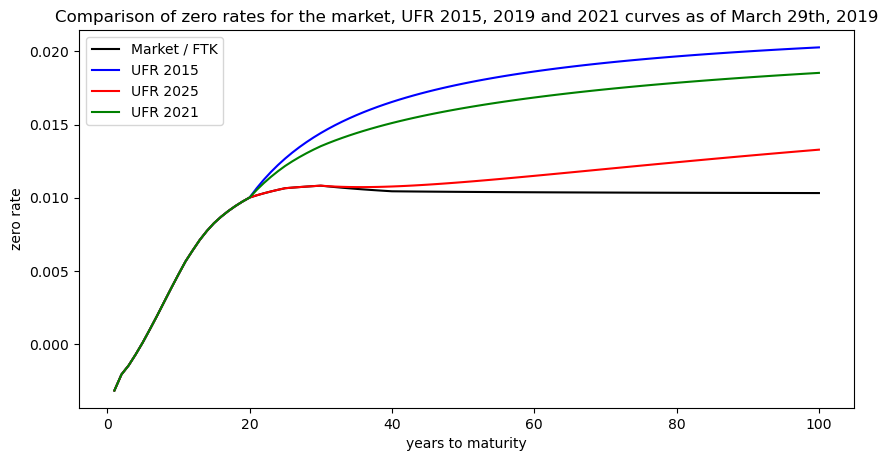

In [14]:
import matplotlib.pyplot as plt

tenors = [ql.PeriodParser.parse(str(i) + 'y') for i in range(1, 101)]

plt.figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title(f'Comparison of zero rates for the market, UFR 2015, 2019 and 2021 curves as of {today}')
plt.xlabel('years to maturity')
plt.ylabel('zero rate')

t, ftk_zeroes = zip(*zero_rates(ftk_handle, tenors))
plt.plot(t, ftk_zeroes, "-k", label="Market / FTK")

_, ufr_2015_zeroes = zip(*zero_rates(ufr_2015_handle, tenors))
plt.plot(t, ufr_2015_zeroes, "-b", label="UFR 2015")

_, ufr_2025_zeroes = zip(*zero_rates(ufr_2025_handle, tenors))
plt.plot(t, ufr_2025_zeroes, "-r", label="UFR 2025")

_, ufr_2021_zeroes = zip(*zero_rates(ufr_2021_handle, tenors))
plt.plot(t, ufr_2021_zeroes, "-g", label="UFR 2021")

plt.legend(loc="upper left")
plt.show()

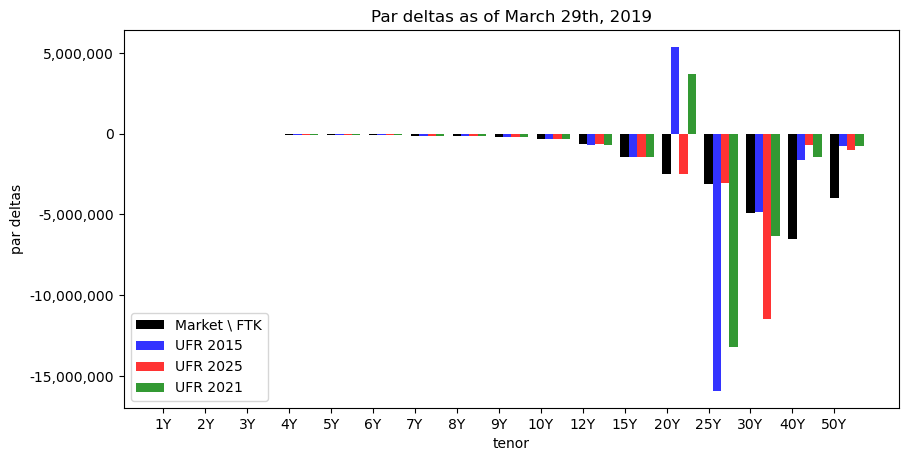

In [15]:
import datetime
import numpy
from matplotlib.ticker import StrMethodFormatter

plt.figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
width = 0.2
x_axis = numpy.arange(len(swap_quotes))

title=f'Par deltas as of {today}'
plt.title(title)

grid, ftk_deltas = zip(*ftk_sensitivities)
grid_str = [str(tnr) for tnr in grid]
plt.bar(x_axis, ftk_deltas, width, color='k', label="Market \ FTK")

_, ufr_2015_deltas = zip(*ufr_2015_sensitivities)
plt.bar(x_axis + width, ufr_2015_deltas, width, alpha=0.8, color='b', label="UFR 2015")

_, ufr_2025_deltas = zip(*ufr_2025_sensitivities)
plt.bar(x_axis + 2 * width, ufr_2025_deltas, width, alpha=0.8, color='r', label="UFR 2025")

_, ufr_2021_deltas = zip(*ufr_2021_sensitivities)
plt.bar(x_axis + 3 * width, ufr_2021_deltas, width, alpha=0.8, color='g', label="UFR 2021")

plt.xticks(x_axis, grid_str)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places
plt.xlabel('tenor')
plt.ylabel('par deltas')
plt.legend(loc="lower left")
plt.show()

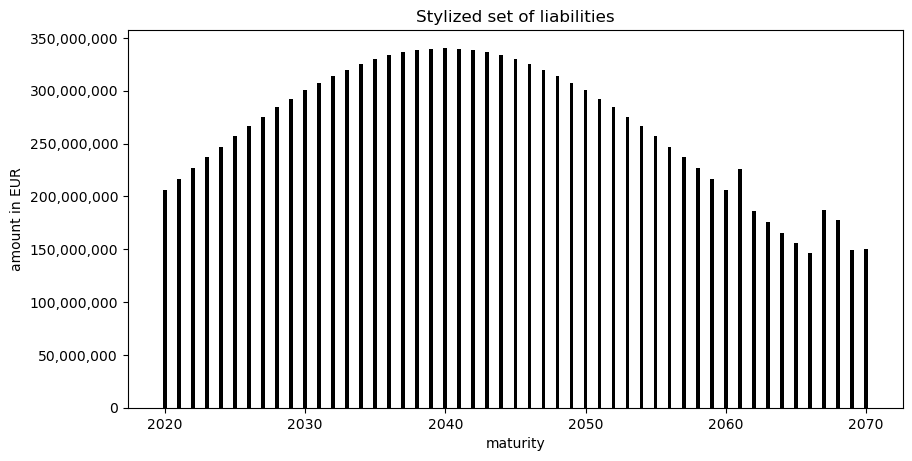

In [16]:
plt.figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
width = 100

title=f'Stylized set of liabilities'
plt.title(title)

dates, flows = zip(*liabilities)
dates = [datetime.datetime(d.year(), d.month(), d.dayOfMonth()) for d in dates]
plt.bar(dates, flows, width, color='k', label="Liabilities")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places
plt.xlabel('maturity')
plt.ylabel('amount in EUR')
plt.show()